# Movie Logs EDA

⚠️ This notebook was generated during a live demo. It is not a complete analysis and may contain errors.

This notebook performs exploratory data analysis (EDA) on:
1. **Local JSON Data**: Movie viewing logs from `sample_data/movie_logs.json`
2. **PostgreSQL Database**: Movies, users, and ratings data

## Analysis Overview
- Data loading and preprocessing
- Basic statistics and data quality assessment
- User behavior analysis
- Movie performance insights
- Device and platform analysis
- Visualization and insights


In [1]:
import pandas as pd
import json

with open('sample_data/movie_logs.json', 'r') as f:
    movie_logs = json.load(f)

movie_logs_df = pd.json_normalize(movie_logs)
movie_logs_df.head()

,timestamp,user_id,session_id,event_type,movie.id,movie.title,movie.genre,movie.year,movie.rating,movie.duration_minutes,...,recommended_movie.title,recommended_movie.genre,recommended_movie.year,recommended_movie.rating,recommended_movie.recommendation_score,recommendation_context.algorithm,recommendation_context.based_on,recommendation_context.user_genre_preferences,user_interaction.subtitles_used,user_interaction.language
0,2024-01-15T14:30:22Z,u_001,sess_abc123,movie_view,m_1001,The Matrix,"[Action, Sci-Fi]",1999.0,8.7,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-15T16:45:10Z,u_002,sess_def456,movie_search,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-15T19:22:33Z,u_003,sess_ghi789,movie_view,m_3001,Inception,"[Action, Drama, Sci-Fi]",2010.0,8.8,148.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-16T10:15:45Z,u_001,sess_jkl012,recommendation_click,NaN,NaN,NaN,NaN,NaN,NaN,...,Blade Runner 2049,"[Action, Drama, Sci-Fi]",2017.0,8.0,0.94,collaborative_filtering,"[m_1001, m_3001]","[Sci-Fi, Action]",NaN,NaN
4,2024-01-16T12:30:18Z,u_004,sess_mno345,movie_view,m_5001,Parasite,"[Drama, Thriller]",2019.0,8.6,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,korean


In [2]:
most_common_event_type = movie_logs_df['event_type'].mode()[0]
print("Most common event_type:", most_common_event_type)


Most common event_type: movie_view


In [3]:
# Number of unique users
num_users = movie_logs_df['user_id'].nunique()
print(f"Unique users: {num_users}")

# Number of unique movies viewed
num_movies = movie_logs_df['movie.id'].nunique()
print(f"Unique movies viewed: {num_movies}")

# Most watched movie (by count)
if 'movie.title' in movie_logs_df.columns:
    most_watched = movie_logs_df['movie.title'].value_counts().idxmax()
    print(f"Most watched movie: {most_watched}")

# Average movie rating given by users (if available)
if 'user_interaction.rating_given' in movie_logs_df.columns:
    avg_rating = movie_logs_df['user_interaction.rating_given'].dropna().mean()
    print(f"Average user rating given: {avg_rating:.2f}")

# Average completion percentage for movie views
if 'user_interaction.completion_percentage' in movie_logs_df.columns:
    avg_completion = movie_logs_df['user_interaction.completion_percentage'].dropna().mean()
    print(f"Average completion percentage: {avg_completion:.1f}%")

# Most popular device type
if 'device.type' in movie_logs_df.columns:
    top_device = movie_logs_df['device.type'].value_counts().idxmax()
    print(f"Most popular device type: {top_device}")

# Most common genre (flatten list if needed)
if 'movie.genre' in movie_logs_df.columns:
    genres = movie_logs_df['movie.genre'].dropna().explode()
    if genres.apply(lambda x: isinstance(x, list)).any():
        # Flatten nested lists
        genres = genres.explode()
    most_common_genre = genres.value_counts().idxmax()
    print(f"Most common genre: {most_common_genre}")


Unique users: 4
Unique movies viewed: 3
Most watched movie: The Matrix
Average user rating given: 9.50
Average completion percentage: 75.7%
Most popular device type: smart_tv
Most common genre: Action


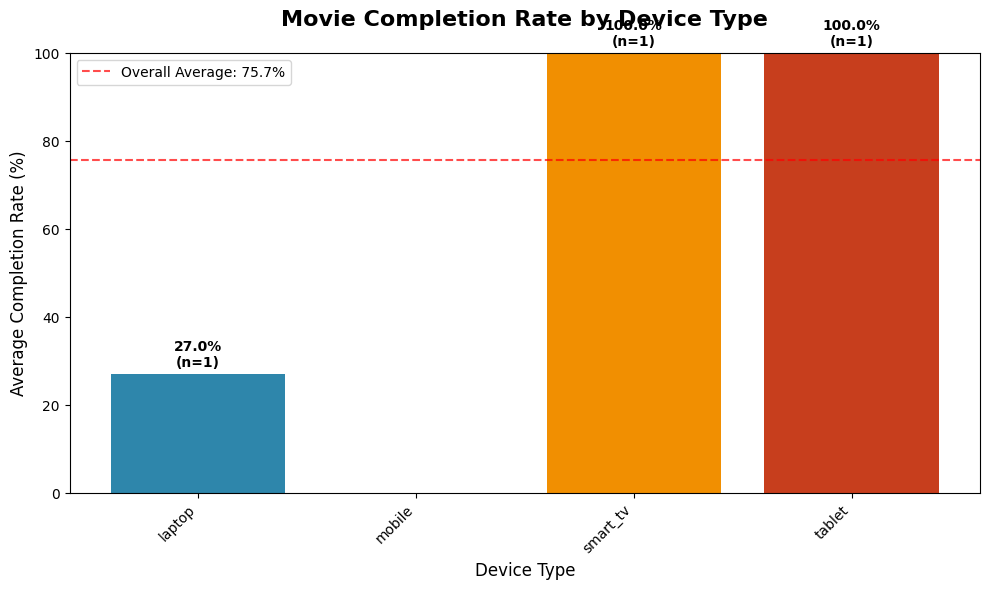

Completion Rate Summary by Device Type:
  Device Type  Average Completion Rate  Count
0      laptop                     27.0      1
1      mobile                      NaN      0
2    smart_tv                    100.0      1
3      tablet                    100.0      1


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate completion rate by device type
if 'device.type' in movie_logs_df.columns and 'user_interaction.completion_percentage' in movie_logs_df.columns:
    completion_by_device = movie_logs_df.groupby('device.type')['user_interaction.completion_percentage'].agg(['mean', 'count']).reset_index()
    completion_by_device.columns = ['Device Type', 'Average Completion Rate', 'Count']
    
    # Create the visualization
    plt.figure(figsize=(10, 6))
    
    # Bar chart showing average completion rate by device type
    bars = plt.bar(completion_by_device['Device Type'], completion_by_device['Average Completion Rate'], 
                   color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
    
    # Add value labels on top of bars
    for bar, avg_completion, count in zip(bars, completion_by_device['Average Completion Rate'], completion_by_device['Count']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{avg_completion:.1f}%\n(n={count})', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.title('Movie Completion Rate by Device Type', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Device Type', fontsize=12)
    plt.ylabel('Average Completion Rate (%)', fontsize=12)
    plt.ylim(0, 100)
    
    # Add a horizontal line for overall average
    overall_avg = movie_logs_df['user_interaction.completion_percentage'].dropna().mean()
    plt.axhline(y=overall_avg, color='red', linestyle='--', alpha=0.7, 
                label=f'Overall Average: {overall_avg:.1f}%')
    plt.legend()
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Display the data table
    print("Completion Rate Summary by Device Type:")
    print(completion_by_device.round(1))
else:
    print("Required columns not found for completion rate analysis")
